In [1]:
import os
import glob
import shutil
import random
import itertools
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator


In [4]:
#=============== Data Preparartion =====================
path = os.getcwd()+'/data/dogsvscats' #used to get current directory
os.chdir(path)
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    

    for c in random.sample(glob.glob('train/cat*'),500):
        shutil.move(c,'train/cat')
    for c in random.sample(glob.glob('train/dog*'),500):
        shutil.move(c,'train/dog')
    for c in random.sample(glob.glob('train/cat*'),100):
        shutil.move(c,'valid/cat')
    for c in random.sample(glob.glob('train/dog*'),100):
        shutil.move(c,'valid/dog')
    for c in random.sample(glob.glob('train/cat*'),50):
        shutil.move(c,'test/cat')
    for c in random.sample(glob.glob('train/dog*'),50):
        shutil.move(c,'test/dog')

In [5]:
train_path = path + '/train'
valid_path = path + '/valid'
test_path = path + '/test'

In [6]:
#===============Data Processing ============
# Shuffle is false for test set because we want to look at unshuffled labels
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
.flow_from_directory(directory=train_path,target_size=(224,224),classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
.flow_from_directory(directory=test_path,target_size=(224,224),classes=['cat', 'dog'],shuffle=False, batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
.flow_from_directory(directory=valid_path,target_size=(224,224),classes=['cat', 'dog'], batch_size=10)

Found 1000 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [7]:
assert train_batches.n == 1000
assert test_batches.n == 100
assert valid_batches.n == 200
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes

In [8]:
# plots images with labels within jupyter notebook
def plotImages(images,labels):
    fig, axes = plt.subplots(2,5,figsize=(20,10))
    axes = axes.flatten()
    for img, ax, label in zip(images,axes,labels):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
imgs, labels = next(train_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..131.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-103.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-109.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..141.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.68..138.22101].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data

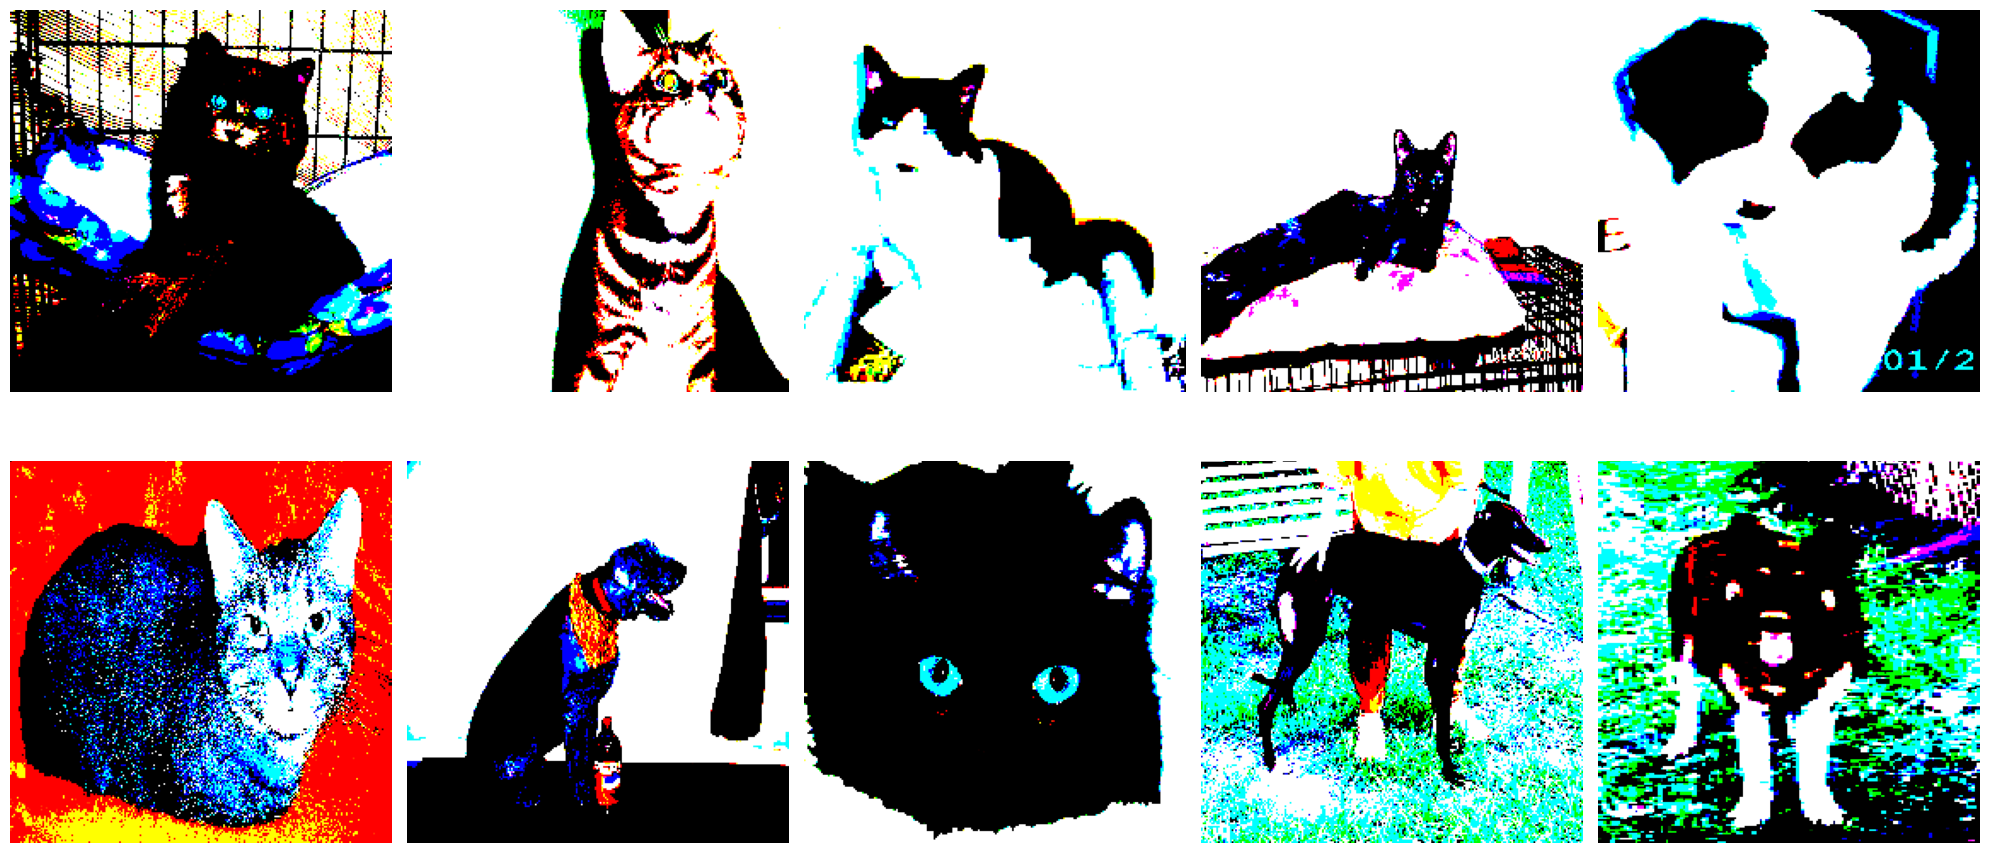

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [10]:
plotImages(imgs,labels)
print(labels)

In [11]:
#======================= Build and Train the Model ===================
# Padding same means the dimensionality of our images doesnt reduces after applying convolution
model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding= 'same',  input_shape=(224,224,3)),
        MaxPool2D(pool_size=(2,2),strides=2),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding= 'same',),
        MaxPool2D(pool_size=(2,2),strides=2),
        Flatten(),
        Dense(2, activation='softmax'),
    ])

In [12]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [13]:
model.compile(Adam(learning_rate=.0001),loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.fit(x=train_batches, validation_data=valid_batches,
           epochs=10, verbose=2)

Epoch 1/10
100/100 - 43s - loss: 23.9530 - accuracy: 0.5320 - val_loss: 7.7093 - val_accuracy: 0.6000 - 43s/epoch - 433ms/step
Epoch 2/10
100/100 - 32s - loss: 3.1581 - accuracy: 0.7280 - val_loss: 3.0434 - val_accuracy: 0.6950 - 32s/epoch - 324ms/step
Epoch 3/10
100/100 - 29s - loss: 0.8787 - accuracy: 0.8700 - val_loss: 3.3999 - val_accuracy: 0.6100 - 29s/epoch - 294ms/step
Epoch 4/10
100/100 - 30s - loss: 0.3660 - accuracy: 0.9390 - val_loss: 2.3005 - val_accuracy: 0.6600 - 30s/epoch - 299ms/step
Epoch 5/10
100/100 - 28s - loss: 0.0783 - accuracy: 0.9810 - val_loss: 2.6293 - val_accuracy: 0.6850 - 28s/epoch - 277ms/step
Epoch 6/10
100/100 - 32s - loss: 0.1338 - accuracy: 0.9690 - val_loss: 3.2925 - val_accuracy: 0.6450 - 32s/epoch - 318ms/step
Epoch 7/10
100/100 - 32s - loss: 0.0315 - accuracy: 0.9950 - val_loss: 2.9291 - val_accuracy: 0.6350 - 32s/epoch - 316ms/step
Epoch 8/10
100/100 - 30s - loss: 0.0070 - accuracy: 0.9980 - val_loss: 3.7302 - val_accuracy: 0.6600 - 30s/epoch - 30

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-74.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.68..88.32].
Clipping input data to 

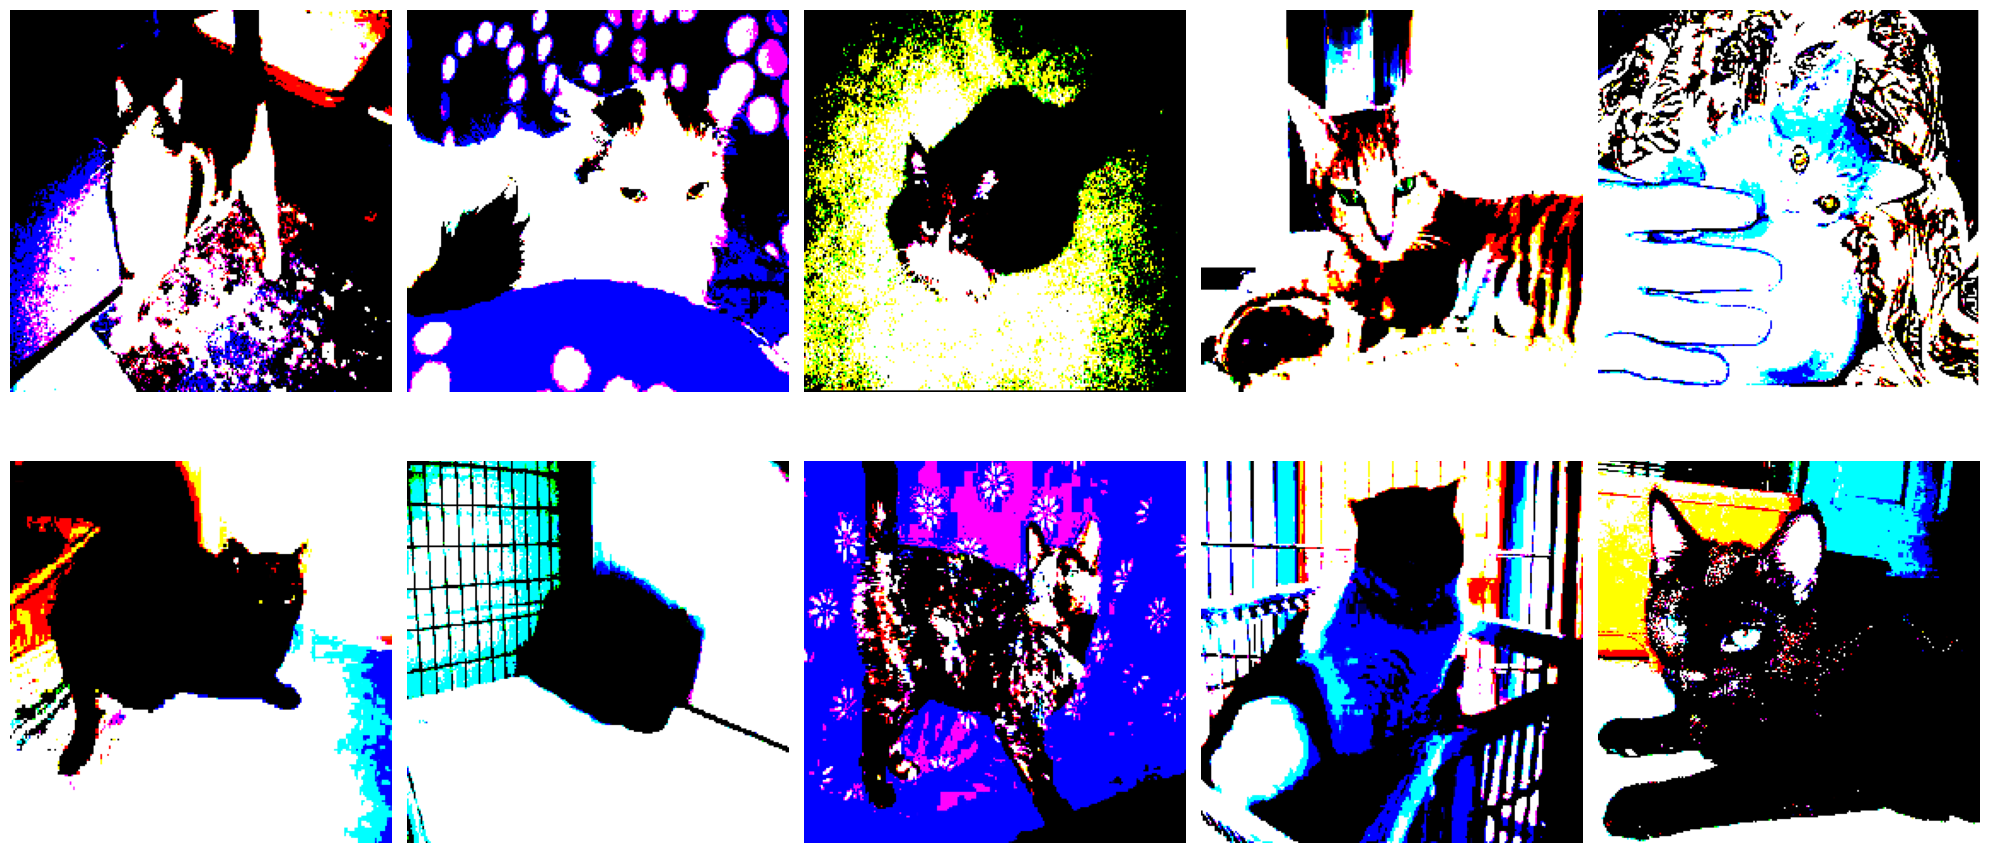

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [15]:
#=================== Prediction ==============

test_imgs, test_labels = next(test_batches)
plotImages(test_imgs, test_labels)
print(test_labels)

In [25]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [26]:
pred = model.predict(x=test_batches, verbose=0) 

In [27]:
np.round(pred)

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [28]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(pred, axis=1))

In [29]:
cm

array([[28, 22],
       [16, 34]], dtype=int64)

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm=cm_plot_labels, title='Confusion Matrix')

TypeError: plot_confusion_matrix() missing 1 required positional argument: 'classes'